# Improve model C


## Initializing and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the specific tensorflow version.
!pip install tensorflow==2.9.0

In [ ]:
# Check that GPU is connected.
%cd /content/drive/MyDrive/TFG_FER
import tensorflow as tf
tf.test.gpu_device_name()

/content/drive/MyDrive/TFG_FER


''

In [ ]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
import cv2

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import ReLU, add, Reshape
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras import backend as K
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
# Check Python and packages' version.
!python3 --version
print("tensorflow: "+tf.__version__)

Python 3.9.16
tensorflow: 2.12.0


## Import dataset and preprocess

In [ ]:
# Load dataset.
data = pd.read_csv("/content/drive/MyDrive/TFG_FER/Datasets_and_packages/fer2013plus.csv")
data

,emotion,pixels,Usage
0,6,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,6,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,6,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,6,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35267,6,181 177 176 156 178 144 136 132 122 107 131 16...,PrivateTest
35268,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35269,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35270,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
# Group data by "Usage".
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
validation = groups[1]
test = groups[0]

In [ ]:
# Remove "Usage" column and group data by labels and pixels.
train = train.drop(labels=['Usage'], axis=1)
validation = validation.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

train_Y = train["emotion"]
validation_Y = validation["emotion"]
test_Y = test["emotion"]

train_X = train["pixels"]
validation_X = validation["pixels"]
test_X = test["pixels"]

In [ ]:
# Number of classes.
num_class = len(set(train_Y))
print(num_class)

7


### Data preprocessing



In [ ]:
# Resize from 0-255 to 0-1 pixel values and reshape into (X, 48, 48, 1).
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [ ]:
train_X = preprocess(train_X)
validation_X = preprocess(validation_X)
test_X = preprocess(test_X)

print(train_X.shape, validation_X.shape, test_X.shape)

(28224, 48, 48, 1) (3529, 48, 48, 1) (3519, 48, 48, 1)


In [ ]:
# Concatenate the arrays along the first axis to create a matrix with all the images.
merged_data_X = np.concatenate([train_X, validation_X, test_X], axis=0)

print(merged_data_X.shape)

(35272, 48, 48, 1)


In [ ]:
# Concatenate the arrays along the first axis to create a matrix with all the labels.
merged_data_Y = np.concatenate([train_Y, validation_Y, test_Y], axis=0)

print(merged_data_Y.shape)

(35272,)


In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the arrays and labels
indices = np.arange(merged_data_X.shape[0])
np.random.shuffle(indices)
merged_data_X = merged_data_X[indices]
merged_data_Y = merged_data_Y[indices]

print(merged_data_X.shape)
print(merged_data_Y.shape)

(35272, 48, 48, 1)
(35272,)


## Functions

### Plot the history of the training and validation

In [ ]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower left')
    ax1.set_ylim([0, 1])

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='lower left')
    ax2.set_ylim([0, max(history.history['loss'])])
    
    plt.show()

### Plot the confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Data augmentation of disgust

In [ ]:
# Create an instance of the ImageDataGenerator class with specified augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=0,   # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0, # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,      # Randomly zoom image 
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any pixels lost after rotation or shifting
)

In [ ]:
def generate_augmented_data(data_X, data_Y, num_aug, emotion_label, datagen):
    # Select the images with the specified emotion label
    selected_images = data_X[data_Y.flatten() == emotion_label]
    
    # Initialize empty arrays to hold the augmented images and their labels
    augmented_images = np.empty((num_aug,) + selected_images.shape[1:])
    augmented_labels = np.empty((num_aug, 1))
    
    # Generate the augmented images and labels
    i = 0
    for batch in datagen.flow(selected_images, batch_size=1):
        augmented_images[i] = batch[0]
        augmented_labels[i] = emotion_label
        i += 1
        if i >= num_aug:
            break
    
    print(augmented_images.shape)
    print(augmented_labels.shape)

    # Return the augmented data arrays
    return augmented_images, augmented_labels

In [ ]:
# Augment disgust.
augmented_dis_X, augmented_dis_Y = generate_augmented_data(merged_data_X, merged_data_Y, 496, 1, datagen)

(496, 48, 48, 1)
(496, 1)


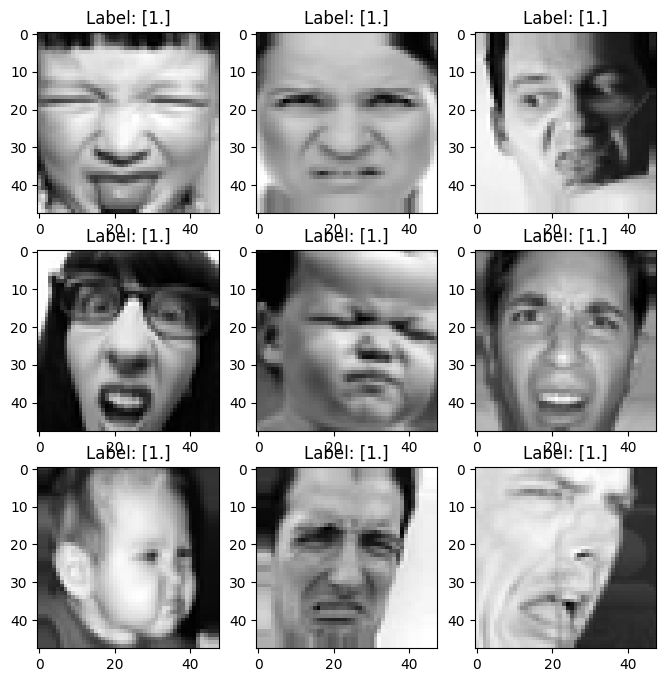

In [ ]:
aug_images=augmented_dis_X
aug_labels=augmented_dis_Y

# Select a random sample of 9 images from the augmented data
sample_indices = np.random.choice(aug_images.shape[0], size=9, replace=False)
sample_images = aug_images[sample_indices]

# Create a 3x3 grid of subplots to display the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    # Get the corresponding image and label
    image = sample_images[i]
    label = aug_labels[sample_indices[i]]

    # Plot the image and label as title
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")

plt.show()

In [ ]:
# One hot encoding
augmented_dis_Y_hot = to_categorical(augmented_dis_Y, num_class)

print(augmented_dis_Y_hot.shape)

(496, 7)


In [ ]:
# One hot encoding
merged_data_Y_hot = to_categorical(merged_data_Y, num_class)

print(merged_data_Y_hot.shape)

(35272, 7)


In [ ]:
# Merge original data with augmented data
merged_X_aug = np.concatenate((merged_data_X, augmented_dis_X), axis=0)
merged_Y_aug = np.concatenate((merged_data_Y_hot, augmented_dis_Y_hot), axis=0)

print(merged_X_aug.shape)
print(merged_Y_aug.shape)

(35768, 48, 48, 1)
(35768, 7)


In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the arrays and labels
indices = np.arange(merged_X_aug.shape[0])
np.random.shuffle(indices)
merged_X_aug = merged_X_aug[indices]
merged_Y_aug = merged_Y_aug[indices]

print(merged_X_aug.shape)
print(merged_Y_aug.shape)

(35768, 48, 48, 1)
(35768, 7)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the arrays and labels into train, validation, and test sets
train_X, val_X, train_Y, val_Y = train_test_split(merged_X_aug, merged_Y_aug, test_size=0.2, stratify=merged_Y_aug)
validation_X, test_X, validation_Y, test_Y = train_test_split(val_X, val_Y, test_size=0.5, stratify=val_Y)

# Check the shapes of the resulting arrays and labels
print(train_X.shape, train_Y.shape)
print(validation_X.shape, validation_Y.shape)
print(test_X.shape, test_Y.shape)

(28614, 48, 48, 1) (28614, 7)
(3577, 48, 48, 1) (3577, 7)
(3577, 48, 48, 1) (3577, 7)


In [ ]:
# Check the training data division across classes.
y = np.argmax(train_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 2489   595   655  7484  3497  3569 10325]


In [ ]:
# Check the validation data division across classes.
y = np.argmax(validation_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 311   74   82  936  437  447 1290]


In [ ]:
# Check the test data division across classes.
y = np.argmax(test_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 311   75   82  935  437  446 1291]


### Build model C

In [ ]:
def mini_VGG16(input_shape, num_classes):
    drop_pram = 0.5
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal", 
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal",
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #2: second CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #3: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #4: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #5: first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #6: second set of FC => RELU layers
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #7: softmax classifier
    model.add(Dense(num_class, kernel_initializer="he_normal"))
    model.add(Activation("softmax"))

    return model

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)


### Train model C

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/model_c/cnn_c_data_aug.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_C.fit(train_X,
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
447/447 [==============================] - 30s 35ms/step - loss: 1.6771 - accuracy: 0.3566 - val_loss: 1.6584 - val_accuracy: 0.3878 - lr: 0.0010
Epoch 2/50
447/447 [==============================] - 17s 36ms/step - loss: 1.3896 - accuracy: 0.4981 - val_loss: 1.2590 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 3/50
447/447 [==============================] - 14s 31ms/step - loss: 1.1990 - accuracy: 0.5805 - val_loss: 1.1403 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 4/50
447/447 [==============================] - 15s 33ms/step - loss: 1.0755 - accuracy: 0.6227 - val_loss: 0.9718 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 5/50
447/447 [==============================] - 14s 31ms/step - loss: 1.0027 - accuracy: 0.6469 - val_loss: 0.9030 - val_accuracy: 0.6747 - lr: 0.0010
Epoch 6/50
447/447 [==============================] - 14s 31ms/step - loss: 0.9533 - accuracy: 0.6612 - val_loss: 0.8778 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 7/50
447/447 [==============================] - 16s 

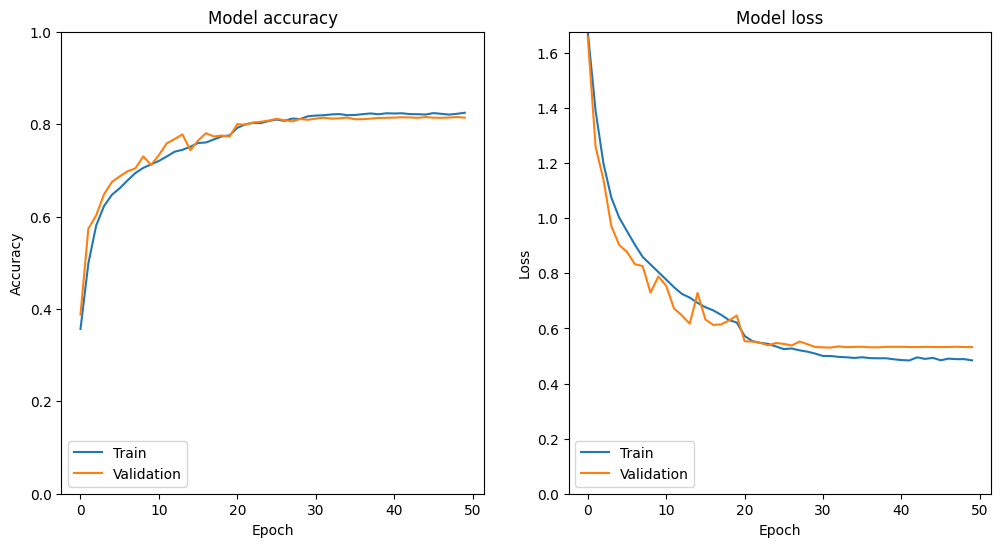

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/model_c/cnn_c_data_aug.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

112/112 [==============================] - 2s 6ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.70      0.76       311
           1       0.71      0.68      0.69        74
           2       0.58      0.41      0.48        82
           3       0.91      0.91      0.91       936
           4       0.70      0.57      0.62       437
           5       0.83      0.84      0.83       447
           6       0.79      0.88      0.83      1290

    accuracy                           0.81      3577
   macro avg       0.76      0.71      0.73      3577
weighted avg       0.81      0.81      0.81      3577



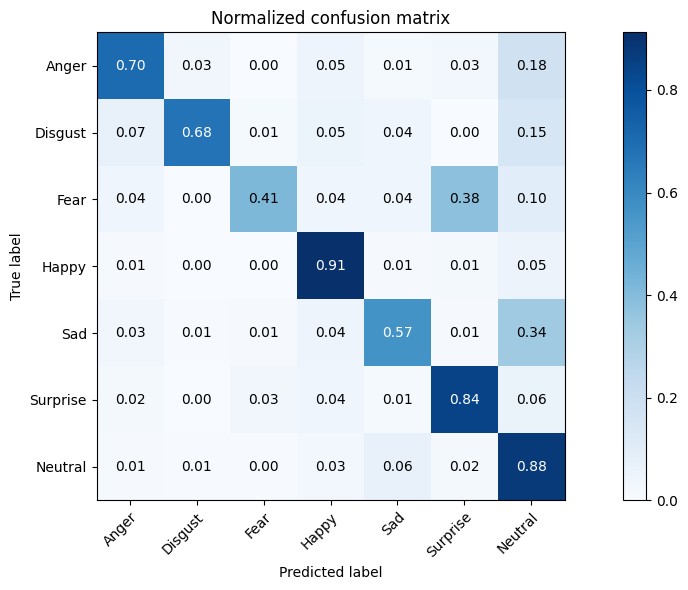

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

112/112 [==============================] - 1s 7ms/step - loss: 0.5272 - accuracy: 0.8093


In [ ]:
test_Y_pred = model_C.predict(test_X)

112/112 [==============================] - 1s 4ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.70      0.76       311
           1       0.71      0.68      0.69        74
           2       0.58      0.41      0.48        82
           3       0.91      0.91      0.91       936
           4       0.70      0.57      0.62       437
           5       0.83      0.84      0.83       447
           6       0.79      0.88      0.83      1290

    accuracy                           0.81      3577
   macro avg       0.76      0.71      0.73      3577
weighted avg       0.81      0.81      0.81      3577



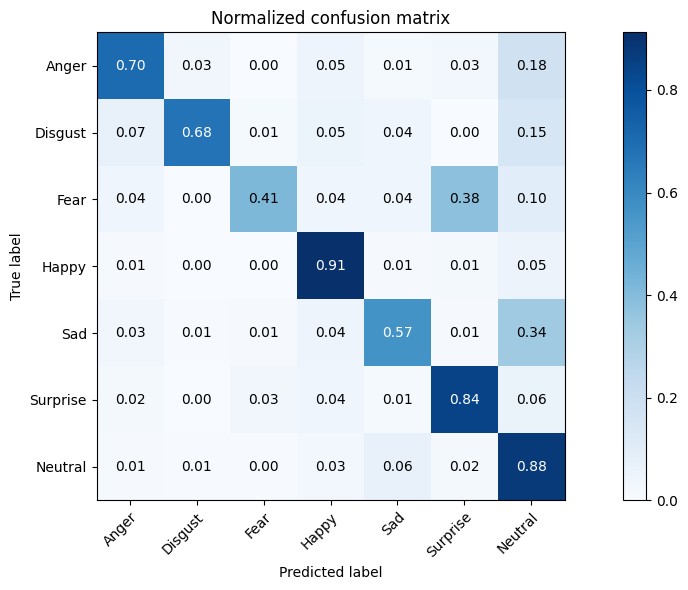

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(test_Y_true, test_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Data augmentation of disgust and fear

In [ ]:
# Augment disgust.
augmented_dis_X, augmented_dis_Y = generate_augmented_data(merged_data_X, merged_data_Y, 496, 1, datagen)

(496, 48, 48, 1)
(496, 1)


In [ ]:
# Augment fear.
augmented_fear_X, augmented_fear_Y = generate_augmented_data(merged_data_X, merged_data_Y, 1638, 2, datagen)

(1638, 48, 48, 1)
(1638, 1)


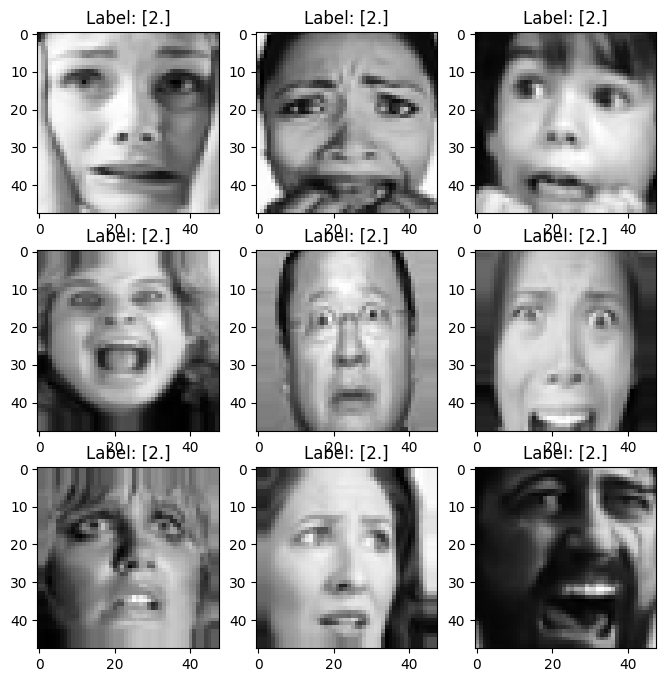

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

aug_images=augmented_fear_X
aug_labels=augmented_fear_Y

# Select a random sample of 9 images from the augmented data
sample_indices = np.random.choice(aug_images.shape[0], size=9, replace=False)
sample_images = aug_images[sample_indices]

# Create a 3x3 grid of subplots to display the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    # Get the corresponding image and label
    image = sample_images[i]
    label = aug_labels[sample_indices[i]]

    # Plot the image and label as title
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")

plt.show()

In [ ]:
# One hot encoding of disgust
augmented_dis_Y_hot = to_categorical(augmented_dis_Y, num_class)

print(augmented_dis_Y_hot.shape)

(496, 7)


In [ ]:
# One hot encoding of fear
augmented_fear_Y_hot = to_categorical(augmented_fear_Y, num_class)

print(augmented_fear_Y_hot.shape)

(1638, 7)


In [ ]:
# One hot encoding of labels
merged_data_Y_hot = to_categorical(merged_data_Y, num_class)

print(merged_data_Y_hot.shape)

(35272, 7)


In [ ]:
# Merge original data with augmented data
merged_X_aug = np.concatenate((merged_data_X, augmented_dis_X), axis=0)
merged_Y_aug = np.concatenate((merged_data_Y_hot, augmented_dis_Y_hot, merged_data_fear_hot), axis=0)

print(merged_X_aug.shape)
print(merged_Y_aug.shape)

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the arrays and labels
indices = np.arange(merged_X_aug.shape[0])
np.random.shuffle(indices)
merged_X_aug = merged_X_aug[indices]
merged_Y_aug = merged_Y_aug[indices]

print(merged_X_aug.shape)
print(merged_Y_aug.shape)

(35768, 48, 48, 1)
(35768, 7)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the arrays and labels into train, validation, and test sets
train_X, val_X, train_Y, val_Y = train_test_split(merged_X_aug, merged_Y_aug, test_size=0.2, stratify=merged_Y_aug)
validation_X, test_X, validation_Y, test_Y = train_test_split(val_X, val_Y, test_size=0.5, stratify=val_Y)

# Check the shapes of the resulting arrays and labels
print(train_X.shape, train_Y.shape)
print(validation_X.shape, validation_Y.shape)
print(test_X.shape, test_Y.shape)

(28614, 48, 48, 1) (28614, 7)
(3577, 48, 48, 1) (3577, 7)
(3577, 48, 48, 1) (3577, 7)


In [ ]:
# Check the training data division across classes.
y = np.argmax(train_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 2489   595   655  7484  3497  3569 10325]


In [ ]:
# Check the validation data division across classes.
y = np.argmax(validation_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 311   74   82  936  437  447 1290]


In [ ]:
# Check the test data division across classes.
y = np.argmax(test_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 311   75   82  935  437  446 1291]


### Build model C

In [ ]:
def mini_VGG16(input_shape, num_classes):
    drop_pram = 0.5
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal", 
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal",
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #2: second CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #3: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #4: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #5: first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #6: second set of FC => RELU layers
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #7: softmax classifier
    model.add(Dense(num_class, kernel_initializer="he_normal"))
    model.add(Activation("softmax"))

    return model

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)

### Train model C

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_c_data_aug_2.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_C.fit(train_X,
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
467/467 [==============================] - 18s 32ms/step - loss: 1.6842 - accuracy: 0.3619 - val_loss: 1.8099 - val_accuracy: 0.3570 - lr: 0.0010
Epoch 2/50
467/467 [==============================] - 16s 33ms/step - loss: 1.3973 - accuracy: 0.5077 - val_loss: 1.5310 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 3/50
467/467 [==============================] - 14s 31ms/step - loss: 1.2212 - accuracy: 0.5704 - val_loss: 1.0971 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 4/50
467/467 [==============================] - 14s 31ms/step - loss: 1.0848 - accuracy: 0.6175 - val_loss: 0.9772 - val_accuracy: 0.6530 - lr: 0.0010
Epoch 5/50
467/467 [==============================] - 14s 30ms/step - loss: 0.9905 - accuracy: 0.6476 - val_loss: 0.8722 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 6/50
467/467 [==============================] - 14s 31ms/step - loss: 0.9297 - accuracy: 0.6723 - val_loss: 0.9842 - val_accuracy: 0.6285 - lr: 0.0010
Epoch 7/50
467/467 [==============================] - 15s 

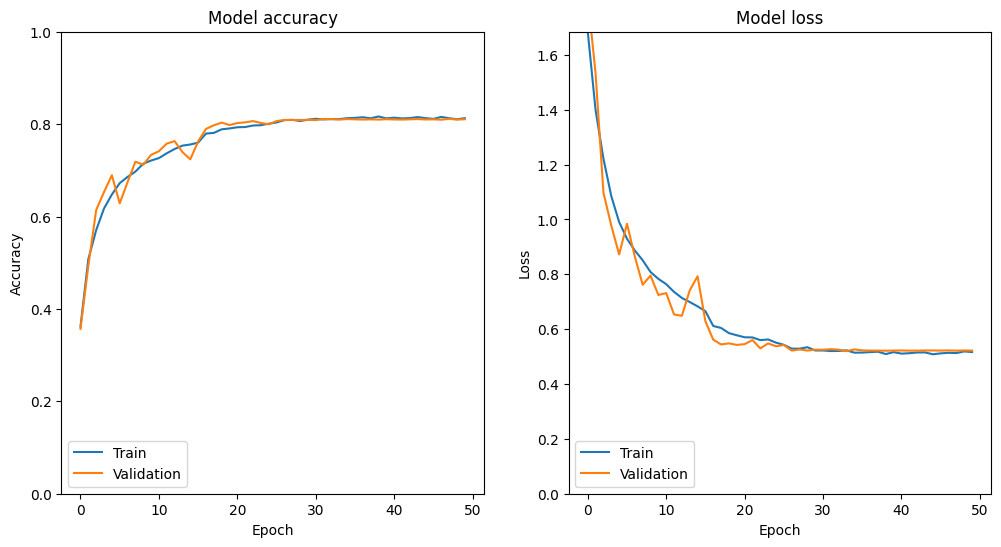

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_c_data_aug_2.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

117/117 [==============================] - 1s 6ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       311
           1       0.79      0.62      0.70        74
           2       0.85      0.73      0.79       246
           3       0.89      0.91      0.90       936
           4       0.70      0.51      0.59       437
           5       0.82      0.85      0.83       446
           6       0.79      0.89      0.83      1291

    accuracy                           0.81      3741
   macro avg       0.80      0.74      0.76      3741
weighted avg       0.81      0.81      0.81      3741



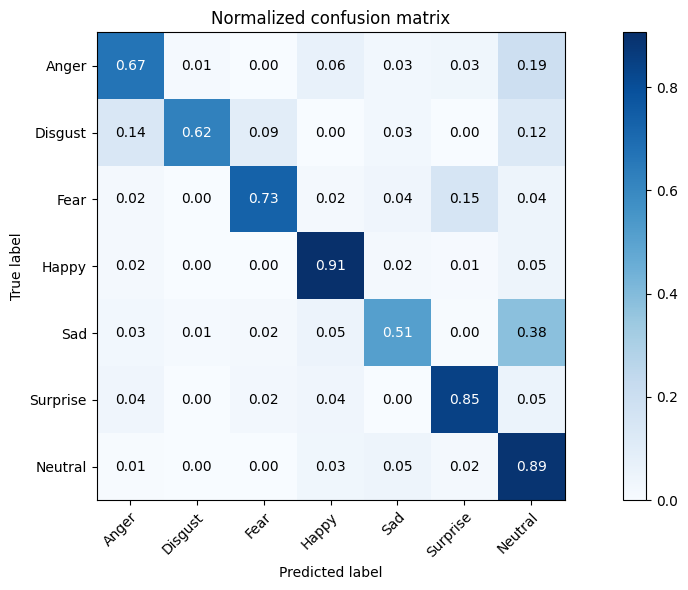

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

117/117 [==============================] - 1s 8ms/step - loss: 0.5327 - accuracy: 0.8081


In [ ]:
test_Y_pred = model_C.predict(test_X)

117/117 [==============================] - 1s 5ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       311
           1       0.79      0.62      0.70        74
           2       0.85      0.73      0.79       246
           3       0.89      0.91      0.90       936
           4       0.70      0.51      0.59       437
           5       0.82      0.85      0.83       446
           6       0.79      0.89      0.83      1291

    accuracy                           0.81      3741
   macro avg       0.80      0.74      0.76      3741
weighted avg       0.81      0.81      0.81      3741



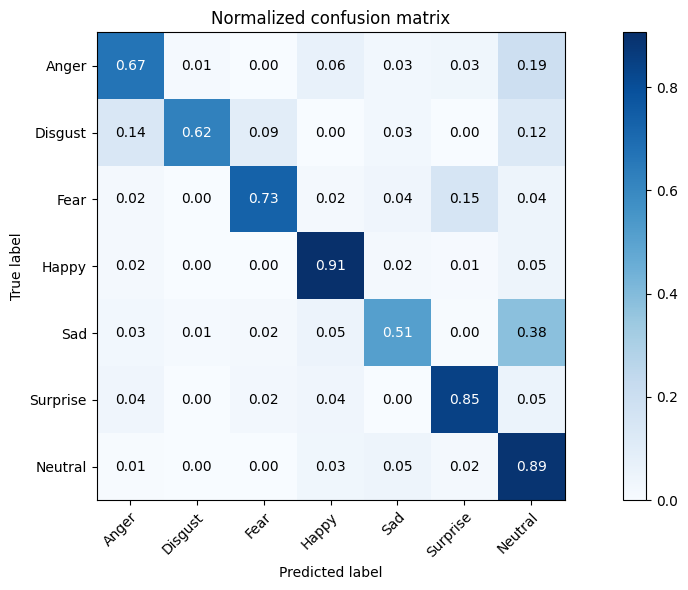

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Class weights using 'balanced'

In [ ]:
# Execute data augmentation of disgust and fear before this.

from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_Y.argmax(axis=1)), y=train_Y.argmax(axis=1))

# Create dictionary
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
class_weight_dict

{0: 1.7174998565115078,
 1: 7.184633853541417,
 2: 2.1743932567940707,
 3: 0.5711995113384745,
 4: 1.2224355570080476,
 5: 1.1977744866509226,
 6: 0.41406985110975814}

### Build model C

In [ ]:
def mini_VGG16(input_shape, num_classes):
    drop_pram = 0.5
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal", 
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal",
                     input_shape = (input_shape)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #2: second CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #3: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #4: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #5: first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #6: second set of FC => RELU layers
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Block #7: softmax classifier
    model.add(Dense(num_class, kernel_initializer="he_normal"))
    model.add(Activation("softmax"))

    return model

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)

### Train model C

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_data_aug3.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_C.fit(train_X,
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      class_weight=class_weight_dict,
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
467/467 [==============================] - 18s 33ms/step - loss: 2.0210 - accuracy: 0.1506 - val_loss: 2.2333 - val_accuracy: 0.0229 - lr: 0.0010
Epoch 2/50
467/467 [==============================] - 15s 32ms/step - loss: 1.8299 - accuracy: 0.2232 - val_loss: 2.1208 - val_accuracy: 0.1156 - lr: 0.0010
Epoch 3/50
467/467 [==============================] - 15s 32ms/step - loss: 1.6500 - accuracy: 0.3066 - val_loss: 2.3629 - val_accuracy: 0.1592 - lr: 0.0010
Epoch 4/50
467/467 [==============================] - 14s 31ms/step - loss: 1.4585 - accuracy: 0.4271 - val_loss: 2.0067 - val_accuracy: 0.3041 - lr: 0.0010
Epoch 5/50
467/467 [==============================] - 14s 31ms/step - loss: 1.2885 - accuracy: 0.5088 - val_loss: 1.2427 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 6/50
467/467 [==============================] - 15s 33ms/step - loss: 1.1701 - accuracy: 0.5531 - val_loss: 1.1790 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 7/50
467/467 [==============================] - 16s 

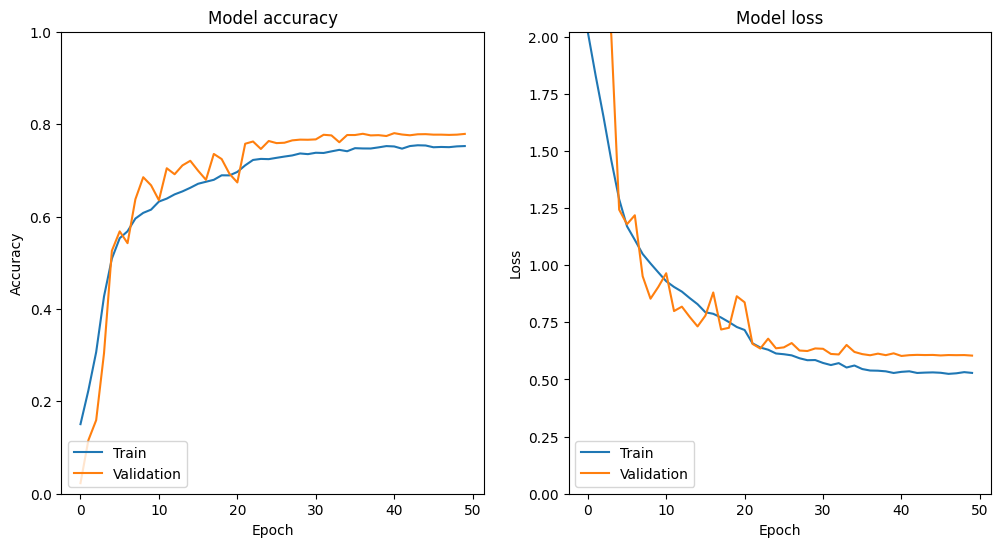

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_data_aug3.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

117/117 [==============================] - 1s 5ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.62      0.79      0.69       311
           1       0.62      0.80      0.70        74
           2       0.82      0.84      0.83       246
           3       0.89      0.86      0.88       936
           4       0.55      0.67      0.60       437
           5       0.79      0.86      0.83       446
           6       0.85      0.71      0.77      1291

    accuracy                           0.78      3741
   macro avg       0.74      0.79      0.76      3741
weighted avg       0.79      0.78      0.78      3741



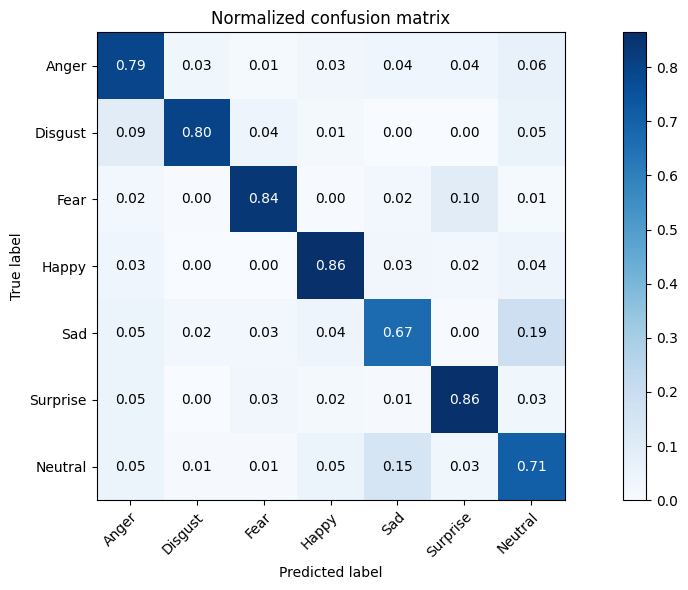

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

117/117 [==============================] - 2s 8ms/step - loss: 0.6139 - accuracy: 0.7669


In [ ]:
test_Y_pred = model_C.predict(test_X)

117/117 [==============================] - 1s 6ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.62      0.79      0.69       311
           1       0.62      0.80      0.70        74
           2       0.82      0.84      0.83       246
           3       0.89      0.86      0.88       936
           4       0.55      0.67      0.60       437
           5       0.79      0.86      0.83       446
           6       0.85      0.71      0.77      1291

    accuracy                           0.78      3741
   macro avg       0.74      0.79      0.76      3741
weighted avg       0.79      0.78      0.78      3741



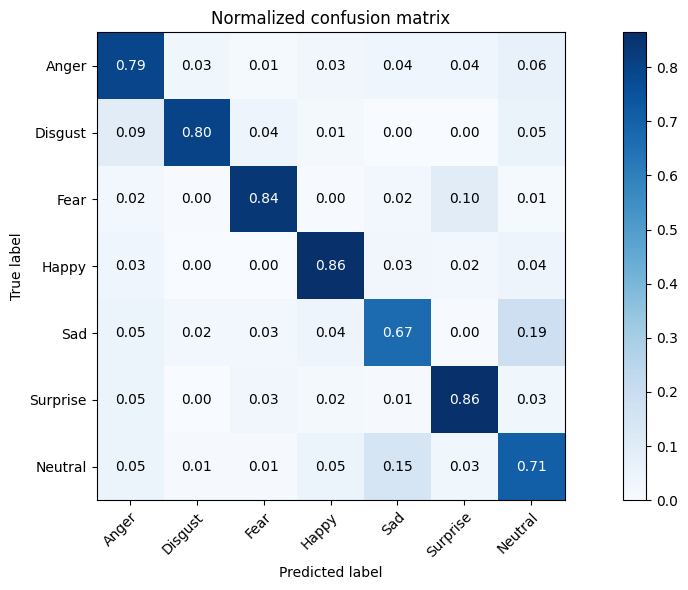

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(test_Y_true, test_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Class weights using 'adjusted'

In [ ]:
class_weight_dict

{0: 1.7174998565115078,
 1: 7.184633853541417,
 2: 2.1743932567940707,
 3: 0.5711995113384745,
 4: 1.2224355570080476,
 5: 1.1977744866509226,
 6: 0.41406985110975814}

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = {0:1.7, 1:6.0, 2:2.2, 3:0.6, 4:1.7, 5:1.2, 6:0.4 }

### Train model C

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_data_aug4.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_C.fit(train_X,
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      class_weight=class_weights,
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
467/467 [==============================] - 18s 36ms/step - loss: 2.2809 - accuracy: 0.1949 - val_loss: 2.1466 - val_accuracy: 0.0431 - lr: 0.0010
Epoch 2/50
467/467 [==============================] - 15s 33ms/step - loss: 2.0724 - accuracy: 0.2629 - val_loss: 2.4458 - val_accuracy: 0.0725 - lr: 0.0010
Epoch 3/50
467/467 [==============================] - 14s 31ms/step - loss: 1.9167 - accuracy: 0.3247 - val_loss: 1.7202 - val_accuracy: 0.3093 - lr: 0.0010
Epoch 4/50
467/467 [==============================] - 14s 31ms/step - loss: 1.6966 - accuracy: 0.4172 - val_loss: 1.4642 - val_accuracy: 0.4599 - lr: 0.0010
Epoch 5/50
467/467 [==============================] - 14s 31ms/step - loss: 1.5083 - accuracy: 0.5076 - val_loss: 1.2370 - val_accuracy: 0.5218 - lr: 0.0010
Epoch 6/50
467/467 [==============================] - 15s 31ms/step - loss: 1.3767 - accuracy: 0.5542 - val_loss: 0.9640 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 7/50
467/467 [==============================] - 15s 

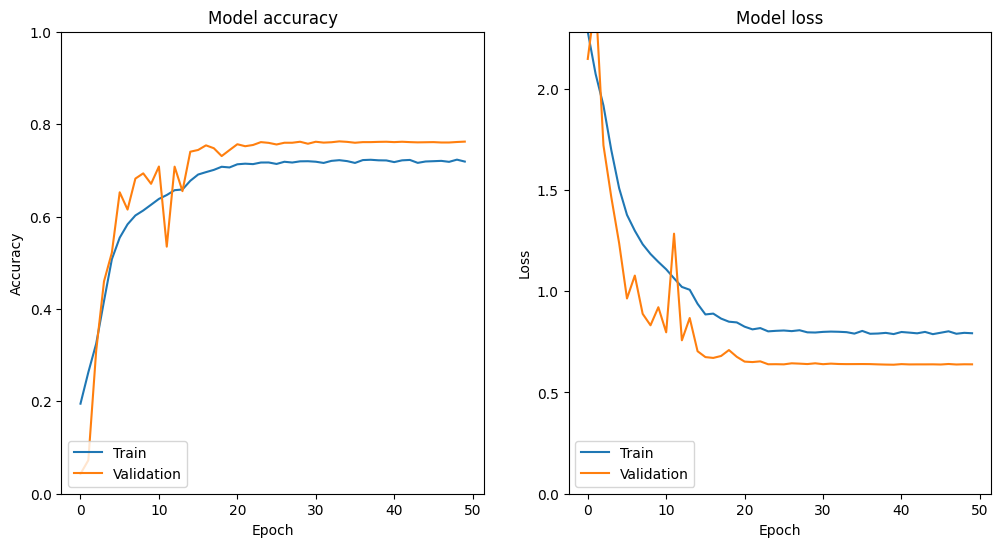

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_data_aug4.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

117/117 [==============================] - 1s 4ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       311
           1       0.56      0.82      0.67        74
           2       0.75      0.79      0.77       246
           3       0.90      0.83      0.87       936
           4       0.50      0.69      0.58       437
           5       0.80      0.81      0.81       446
           6       0.83      0.73      0.78      1291

    accuracy                           0.76      3741
   macro avg       0.71      0.77      0.73      3741
weighted avg       0.78      0.76      0.77      3741



In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       311
           1       0.56      0.82      0.67        74
           2       0.75      0.79      0.77       246
           3       0.90      0.83      0.87       936
           4       0.50      0.69      0.58       437
           5       0.80      0.81      0.81       446
           6       0.83      0.73      0.78      1291

    accuracy                           0.76      3741
   macro avg       0.71      0.77      0.73      3741
weighted avg       0.78      0.76      0.77      3741



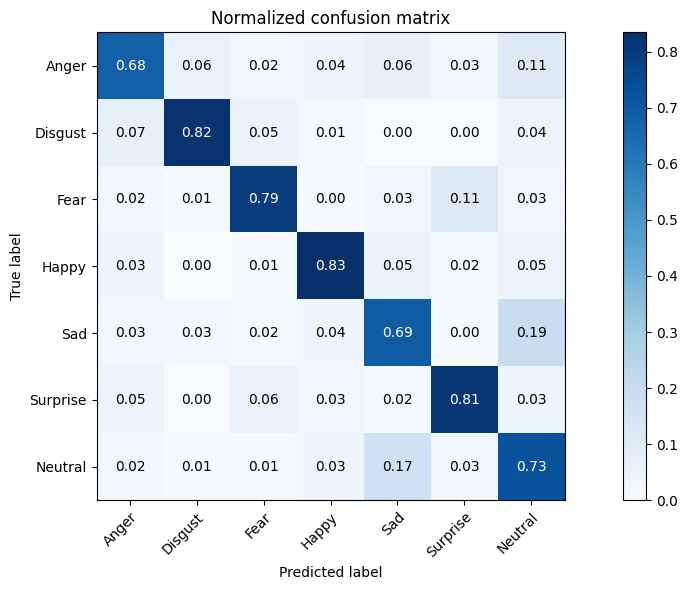

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

117/117 [==============================] - 1s 7ms/step - loss: 0.6652 - accuracy: 0.7543


In [ ]:
test_Y_pred = model_C.predict(test_X)

117/117 [==============================] - 1s 6ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       311
           1       0.56      0.82      0.67        74
           2       0.75      0.79      0.77       246
           3       0.90      0.83      0.87       936
           4       0.50      0.69      0.58       437
           5       0.80      0.81      0.81       446
           6       0.83      0.73      0.78      1291

    accuracy                           0.76      3741
   macro avg       0.71      0.77      0.73      3741
weighted avg       0.78      0.76      0.77      3741



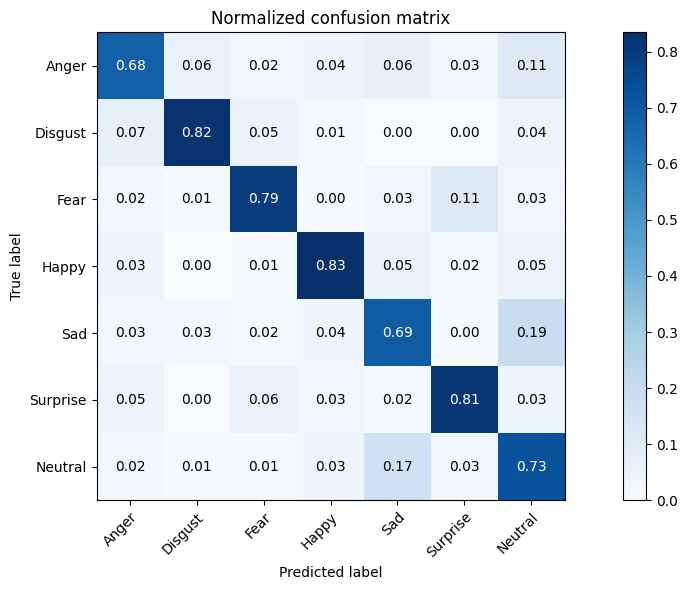

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Optimizing architecture

### Build model C

In [ ]:
from keras.regularizers import l2

# Dropout of last layers have been incremented to 0.5
# l2 regularization at each layer
def mini_VGG16(input_shape, num_classes):
    weight_decay = 0.001
    drop_pram = 0.5
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal", 
                     kernel_regularizer=l2(weight_decay), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #2: second CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #3: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #4: third CONV => RELU => CONV => RELU => POOL
    # layer set
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal",
                     kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_pram))

    # Block #5: first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer="he_normal", 
                    kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Block #6: second set of FC => RELU layers
    model.add(Dense(64, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Block #7: softmax classifier
    model.add(Dense(num_class, kernel_initializer="he_normal"))
    model.add(Activation("softmax"))

    return model

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)

### Train model C

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_c_data_aug5.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_C.fit(train_X,
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      class_weight=class_weight_dict,
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
467/467 [==============================] - 18s 32ms/step - loss: 4.0017 - accuracy: 0.1573 - val_loss: 3.4547 - val_accuracy: 0.0205 - lr: 0.0010
Epoch 2/50
467/467 [==============================] - 15s 32ms/step - loss: 3.0905 - accuracy: 0.1440 - val_loss: 3.1346 - val_accuracy: 0.0202 - lr: 0.0010
Epoch 3/50
467/467 [==============================] - 15s 33ms/step - loss: 2.4439 - accuracy: 0.1929 - val_loss: 2.7426 - val_accuracy: 0.0498 - lr: 0.0010
Epoch 4/50
467/467 [==============================] - 15s 33ms/step - loss: 2.1081 - accuracy: 0.2254 - val_loss: 3.0998 - val_accuracy: 0.0296 - lr: 0.0010
Epoch 5/50
467/467 [==============================] - 16s 34ms/step - loss: 1.8986 - accuracy: 0.3056 - val_loss: 2.3249 - val_accuracy: 0.2166 - lr: 0.0010
Epoch 6/50
467/467 [==============================] - 15s 33ms/step - loss: 1.8096 - accuracy: 0.3569 - val_loss: 1.7516 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 7/50
467/467 [==============================] - 15s 

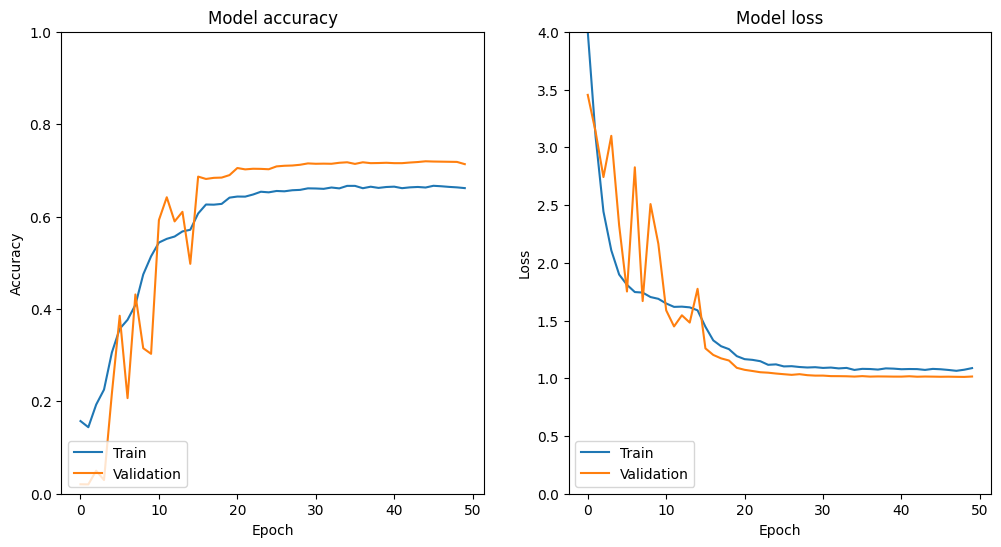

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_c_data_aug5.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

117/117 [==============================] - 1s 4ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.57      0.72      0.64       311
           1       0.60      0.78      0.68        74
           2       0.77      0.74      0.76       246
           3       0.89      0.82      0.85       936
           4       0.38      0.49      0.43       437
           5       0.70      0.87      0.77       446
           6       0.81      0.65      0.72      1291

    accuracy                           0.71      3741
   macro avg       0.68      0.72      0.69      3741
weighted avg       0.74      0.71      0.72      3741



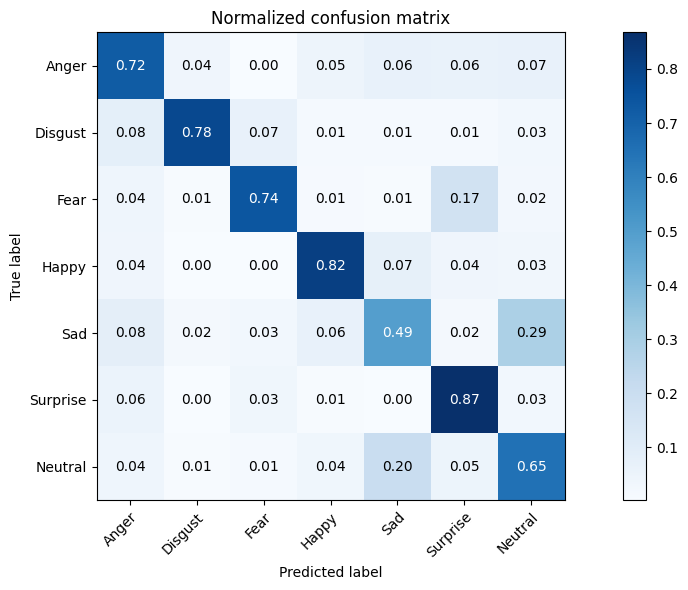

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

117/117 [==============================] - 1s 6ms/step - loss: 1.0191 - accuracy: 0.7169


In [ ]:
test_Y_pred = model_C.predict(test_X)

117/117 [==============================] - 1s 4ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.57      0.72      0.64       311
           1       0.60      0.78      0.68        74
           2       0.77      0.74      0.76       246
           3       0.89      0.82      0.85       936
           4       0.38      0.49      0.43       437
           5       0.70      0.87      0.77       446
           6       0.81      0.65      0.72      1291

    accuracy                           0.71      3741
   macro avg       0.68      0.72      0.69      3741
weighted avg       0.74      0.71      0.72      3741



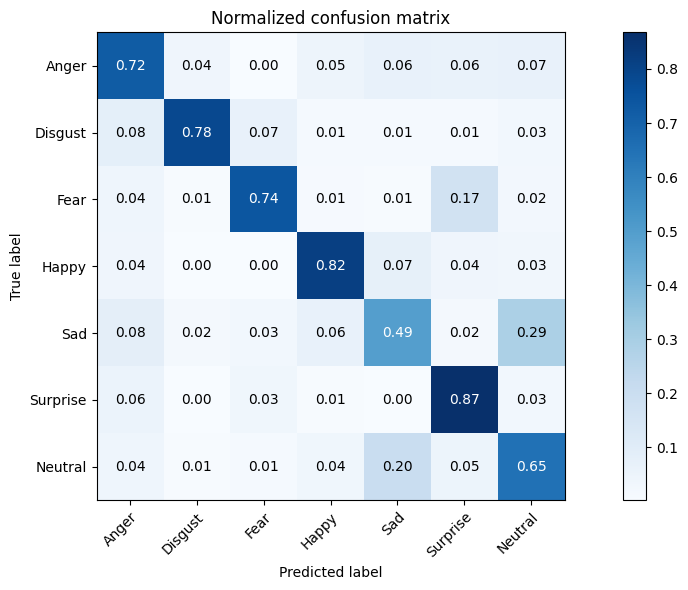

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(test_Y_true, test_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

### Build model C

## Undersample to balance dataset

In [ ]:
# Execute data augmentation of disgust and fear before this.

merged_data_Y = np.argmax(merged_Y_aug, axis=1)

In [ ]:
def undersample(images, labels, num_keep):
    # Determine the number of images to keep per class
    counts = np.bincount(labels.flatten())
    num_per_class = np.minimum(counts, num_keep)
    
    # Undersample the dataset
    indices = []
    for i in range(7):
        idx = np.where(labels == i)[0]
        np.random.shuffle(idx)
        indices.extend(idx[:num_per_class[i]])
    np.random.shuffle(indices)
    undersampled_images = images[indices]
    undersampled_labels = labels[indices]
    
    return undersampled_images, undersampled_labels

In [ ]:
under_X, under_Y = undersample(merged_data_X, merged_data_Y, 4000)

In [ ]:
print(under_X.shape)
print(under_Y.shape)

(22312, 48, 48, 1)
(22312,)


In [ ]:
under_Y = to_categorical(under_Y, num_class)
print(under_Y.shape)

(22312, 7)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the arrays and labels into train, validation, and test sets
train_X, val_X, train_Y, val_Y = train_test_split(under_X, under_Y, test_size=0.2, stratify=under_Y)
validation_X, test_X, validation_Y, test_Y = train_test_split(val_X, val_Y, test_size=0.5, stratify=val_Y)

# Check the shapes of the resulting arrays and labels
print(train_X.shape, train_Y.shape)
print(validation_X.shape, validation_Y.shape)
print(test_X.shape, test_Y.shape)

(17849, 48, 48, 1) (17849, 7)
(2231, 48, 48, 1) (2231, 7)
(2232, 48, 48, 1) (2232, 7)


In [ ]:
# Check the training data division across classes.
y = np.argmax(train_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[2489  595 1965 3200 3200 3200 3200]


In [ ]:
# Check the validation data division across classes.
y = np.argmax(validation_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[311  74 246 400 400 400 400]


In [ ]:
# Check the test data division across classes.
y = np.argmax(test_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[311  75 246 400 400 400 400]


### Build model C

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)

### Train model C

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/cnn_data_aug7.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 32

# Fit the model.
history = model_C.fit(train_X,
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
557/557 [==============================] - 24s 24ms/step - loss: 1.9372 - accuracy: 0.2212 - val_loss: 1.9783 - val_accuracy: 0.1861 - lr: 0.0010
Epoch 2/50
557/557 [==============================] - 10s 17ms/step - loss: 1.7101 - accuracy: 0.3162 - val_loss: 1.8446 - val_accuracy: 0.2174 - lr: 0.0010
Epoch 3/50
557/557 [==============================] - 9s 17ms/step - loss: 1.5304 - accuracy: 0.4102 - val_loss: 1.6289 - val_accuracy: 0.3528 - lr: 0.0010
Epoch 4/50
557/557 [==============================] - 9s 16ms/step - loss: 1.3761 - accuracy: 0.4811 - val_loss: 1.2137 - val_accuracy: 0.5480 - lr: 0.0010
Epoch 5/50
557/557 [==============================] - 9s 17ms/step - loss: 1.2334 - accuracy: 0.5384 - val_loss: 1.2406 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 6/50
557/557 [==============================] - 10s 18ms/step - loss: 1.1517 - accuracy: 0.5709 - val_loss: 1.0573 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 7/50
557/557 [==============================] - 9s 17ms

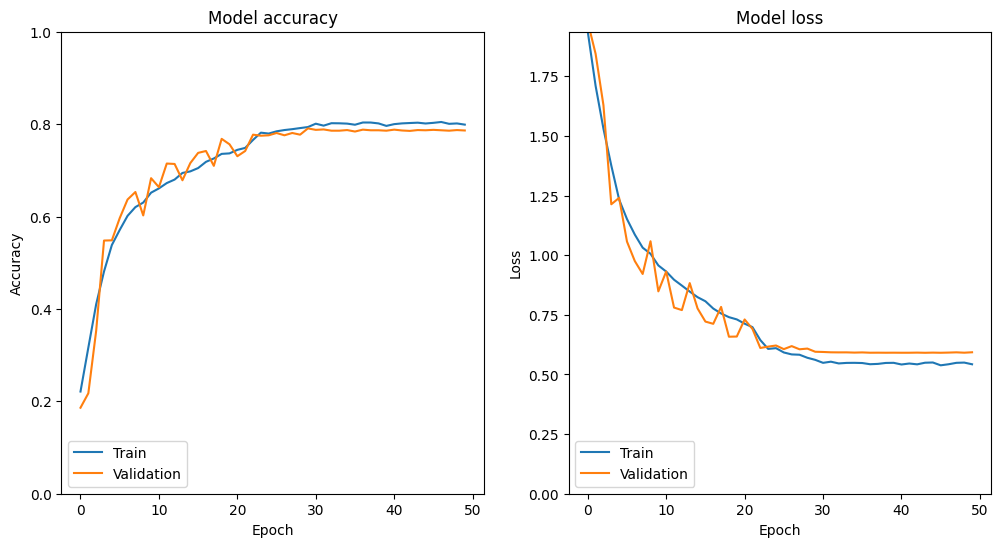

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/cnn_data_aug7.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

70/70 [==============================] - 1s 8ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       311
           1       0.79      0.70      0.74        74
           2       0.83      0.83      0.83       246
           3       0.85      0.87      0.86       400
           4       0.73      0.69      0.71       400
           5       0.83      0.85      0.84       400
           6       0.67      0.73      0.70       400

    accuracy                           0.78      2231
   macro avg       0.79      0.78      0.78      2231
weighted avg       0.78      0.78      0.78      2231



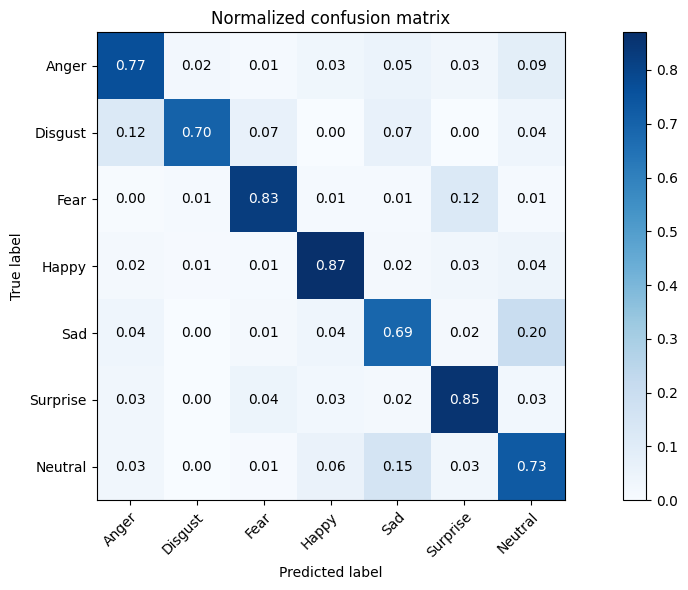

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

70/70 [==============================] - 1s 8ms/step - loss: 0.6117 - accuracy: 0.7818


In [ ]:
test_Y_pred = model_C.predict(test_X)

70/70 [==============================] - 0s 4ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       311
           1       0.79      0.70      0.74        74
           2       0.83      0.83      0.83       246
           3       0.85      0.87      0.86       400
           4       0.73      0.69      0.71       400
           5       0.83      0.85      0.84       400
           6       0.67      0.73      0.70       400

    accuracy                           0.78      2231
   macro avg       0.79      0.78      0.78      2231
weighted avg       0.78      0.78      0.78      2231



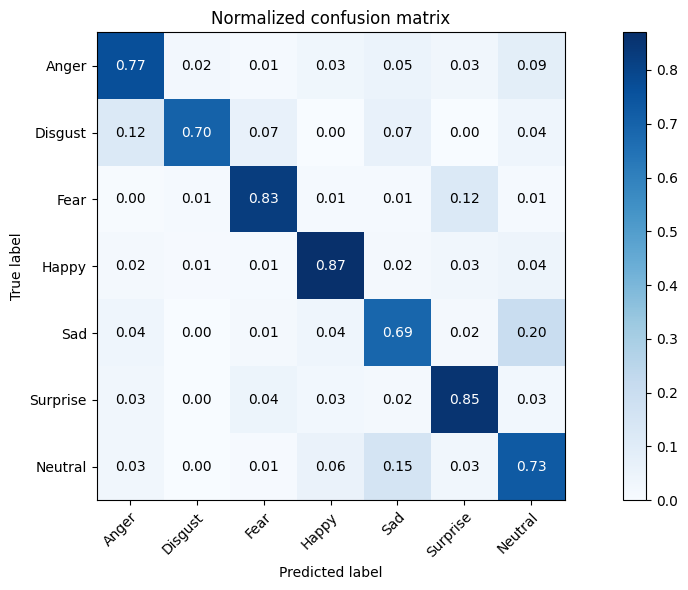

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

## Data augmentation of all classes + class weights

In [ ]:
# Create an instance of the ImageDataGenerator class with specified augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=5,   # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0, # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,      # Randomly zoom image 
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any pixels lost after rotation or shifting
)

In [ ]:
def generate_augmented_data(data_X, data_Y, num_aug, emotion_label, datagen):
    # Select the images with the specified emotion label
    selected_images = data_X[data_Y.flatten() == emotion_label]
    
    # Initialize empty arrays to hold the augmented images and their labels
    augmented_images = np.empty((num_aug,) + selected_images.shape[1:])
    augmented_labels = np.empty((num_aug, 1))
    
    # Generate the augmented images and labels
    i = 0
    for batch in datagen.flow(selected_images, batch_size=1):
        augmented_images[i] = batch[0]
        augmented_labels[i] = emotion_label
        i += 1
        if i >= num_aug:
            break
    
    print(augmented_images.shape)
    print(augmented_labels.shape)

    # Return the augmented data arrays
    return augmented_images, augmented_labels

In [ ]:
# Augment disgust.
augmented_dis_X, augmented_dis_Y = generate_augmented_data(merged_data_X, merged_data_Y, 744, 1, datagen)

(744, 48, 48, 1)
(744, 1)


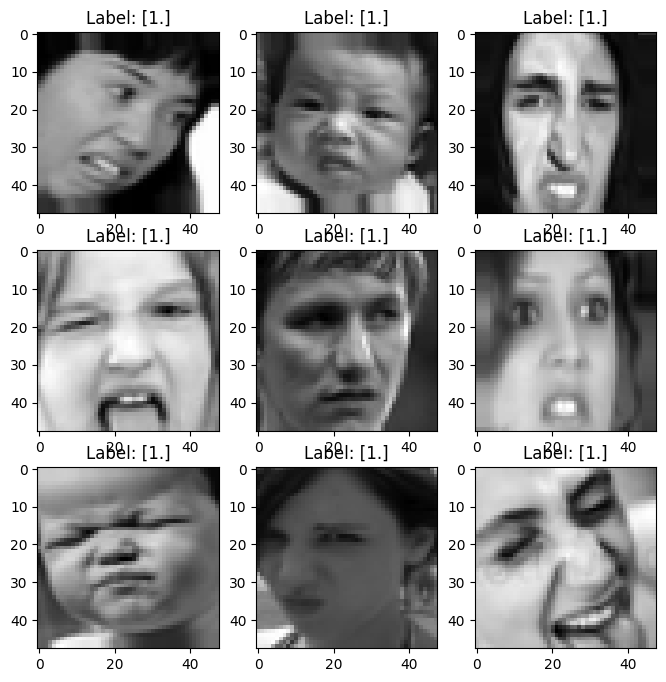

In [ ]:
aug_images=augmented_dis_X
aug_labels=augmented_dis_Y

# Select a random sample of 9 images from the augmented data
sample_indices = np.random.choice(aug_images.shape[0], size=9, replace=False)
sample_images = aug_images[sample_indices]

# Create a 3x3 grid of subplots to display the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    # Get the corresponding image and label
    image = sample_images[i]
    label = aug_labels[sample_indices[i]]

    # Plot the image and label as title
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")

plt.show()

In [ ]:
# Augment fear.
augmented_fear_X, augmented_fear_Y = generate_augmented_data(merged_data_X, merged_data_Y, 4919, 2, datagen)

(4919, 48, 48, 1)
(4919, 1)


In [ ]:
# Augment anger.
augmented_ang_X, augmented_ang_Y = generate_augmented_data(merged_data_X, merged_data_Y, 3111, 0, datagen)

(3111, 48, 48, 1)
(3111, 1)


In [ ]:
# Augment sadness.
augmented_sad_X, augmented_sad_Y = generate_augmented_data(merged_data_X, merged_data_Y, 2186, 4, datagen)

(2186, 48, 48, 1)
(2186, 1)


In [ ]:
# Augment surprise.
augmented_sur_X, augmented_sur_Y = generate_augmented_data(merged_data_X, merged_data_Y, 2000, 5, datagen)

(2000, 48, 48, 1)
(2000, 1)


In [ ]:
# One hot encoding
augmented_dis_Y_hot = to_categorical(augmented_dis_Y, num_class)
augmented_fear_Y_hot = to_categorical(augmented_fear_Y, num_class)
augmented_ang_Y_hot = to_categorical(augmented_ang_Y, num_class)
augmented_sad_Y_hot = to_categorical(augmented_sad_Y, num_class)
augmented_sur_Y_hot = to_categorical(augmented_sur_Y, num_class)

In [ ]:
# One hot encoding
merged_data_Y_hot = to_categorical(merged_data_Y, num_class)

print(merged_data_Y_hot.shape)

(35272, 7)


In [ ]:
# Merge original data with augmented data
merged_X_aug = np.concatenate((merged_data_X, augmented_dis_X, augmented_fear_X, augmented_ang_X, augmented_sad_X, augmented_sur_X), axis=0)
merged_Y_aug = np.concatenate((merged_data_Y_hot, augmented_dis_Y_hot, augmented_fear_Y_hot, augmented_ang_Y_hot, augmented_sad_Y_hot, augmented_sur_Y_hot), axis=0)

print(merged_X_aug.shape)
print(merged_Y_aug.shape)

(48232, 48, 48, 1)
(48232, 7)


In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the arrays and labels
indices = np.arange(merged_X_aug.shape[0])
np.random.shuffle(indices)
merged_X_aug = merged_X_aug[indices]
merged_Y_aug = merged_Y_aug[indices]

print(merged_X_aug.shape)
print(merged_Y_aug.shape)

(48232, 48, 48, 1)
(48232, 7)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the arrays and labels into train, validation, and test sets
train_X, val_X, train_Y, val_Y = train_test_split(merged_X_aug, merged_Y_aug, test_size=0.2, stratify=merged_Y_aug)
validation_X, test_X, validation_Y, test_Y = train_test_split(val_X, val_Y, test_size=0.5, stratify=val_Y)

# Check the shapes of the resulting arrays and labels
print(train_X.shape, train_Y.shape)
print(validation_X.shape, validation_Y.shape)
print(test_X.shape, test_Y.shape)

(38585, 48, 48, 1) (38585, 7)
(4823, 48, 48, 1) (4823, 7)
(4824, 48, 48, 1) (4824, 7)


In [ ]:
# Check the training data division across classes.
y = np.argmax(train_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 4978   794  4590  7484  5245  5169 10325]


In [ ]:
# Check the validation data division across classes.
y = np.argmax(validation_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 622   99  574  935  656  647 1290]


In [ ]:
# Check the test data division across classes.
y = np.argmax(test_Y, axis=1)
class_counts = np.bincount(y)
print(class_counts)

[ 622   99  574  936  656  646 1291]


In [ ]:
# Execute data augmentation of disgust and fear before this.

from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_Y.argmax(axis=1)), y=train_Y.argmax(axis=1))

# Create dictionary
class_weight_dict = dict(enumerate(class_weights))

### Build model C

In [ ]:
model_C = mini_VGG16((48, 48, 1), num_class)

### Train model C

In [ ]:
# Save the model.
path_model = '/content/drive/MyDrive/TFG_FER/CNN/model_c/cnn_c_8.h5'
tf.compat.v1.keras.backend.clear_session()

# Compile the model.
model_C.compile(optimizer=Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)
batch_size = 64

# Fit the model.
history = model_C.fit(train_X,
                      train_Y,
                      batch_size=batch_size, 
                      epochs=50,
                      steps_per_epoch=len(train_X)//batch_size,
                      verbose=1,
                      class_weight=class_weight_dict, 
                      validation_data=(validation_X, validation_Y),
                      validation_steps=len(validation_X)//batch_size,
                      callbacks=[ModelCheckpoint(filepath = path_model), lr_anneal],
                      )

Epoch 1/50
602/602 [==============================] - 29s 27ms/step - loss: 1.9665 - accuracy: 0.1769 - val_loss: 2.2254 - val_accuracy: 0.0338 - lr: 0.0010
Epoch 2/50
602/602 [==============================] - 14s 23ms/step - loss: 1.7429 - accuracy: 0.2712 - val_loss: 1.7794 - val_accuracy: 0.2846 - lr: 0.0010
Epoch 3/50
602/602 [==============================] - 15s 25ms/step - loss: 1.5399 - accuracy: 0.3912 - val_loss: 1.4874 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 4/50
602/602 [==============================] - 14s 23ms/step - loss: 1.3355 - accuracy: 0.5036 - val_loss: 1.3358 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 5/50
602/602 [==============================] - 15s 25ms/step - loss: 1.2023 - accuracy: 0.5566 - val_loss: 1.0367 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 6/50
602/602 [==============================] - 14s 23ms/step - loss: 1.1259 - accuracy: 0.5826 - val_loss: 1.1591 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 7/50
602/602 [==============================] - 14s 

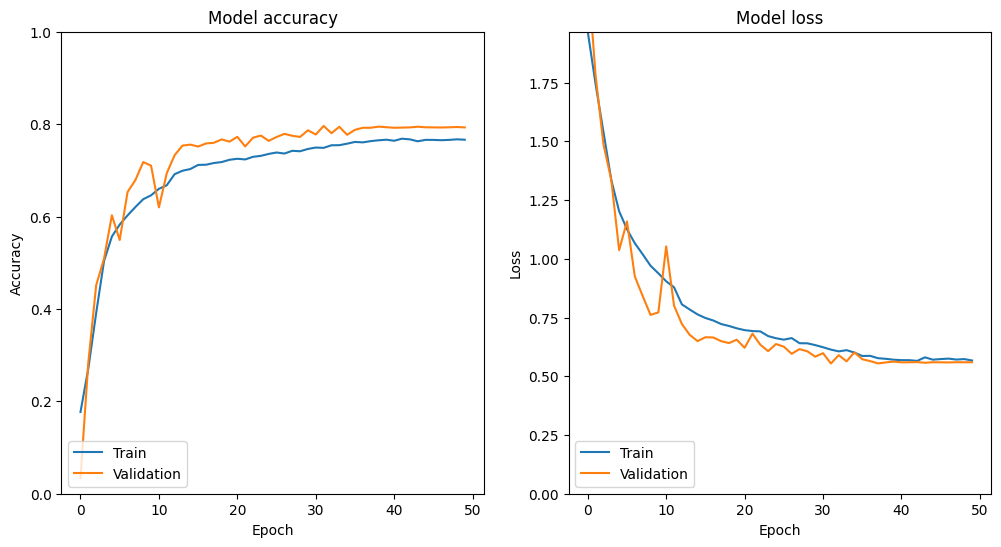

In [ ]:
plot_history(history)

### Evaluation: Validation and testing

In [ ]:
model_C = load_model('/content/drive/MyDrive/TFG_FER/CNN/model_c/cnn_c_8.h5')

In [ ]:
validation_Y_pred = model_C.predict(validation_X)

151/151 [==============================] - 1s 5ms/step


In [ ]:
validation_Y_true = np.argmax(validation_Y, axis=1)
validation_Y_pred = np.argmax(validation_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(validation_Y_true, validation_Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       622
           1       0.51      0.93      0.65        99
           2       0.77      0.93      0.84       574
           3       0.86      0.89      0.87       935
           4       0.70      0.63      0.66       656
           5       0.86      0.79      0.82       647
           6       0.81      0.77      0.79      1290

    accuracy                           0.79      4823
   macro avg       0.76      0.81      0.77      4823
weighted avg       0.80      0.79      0.79      4823



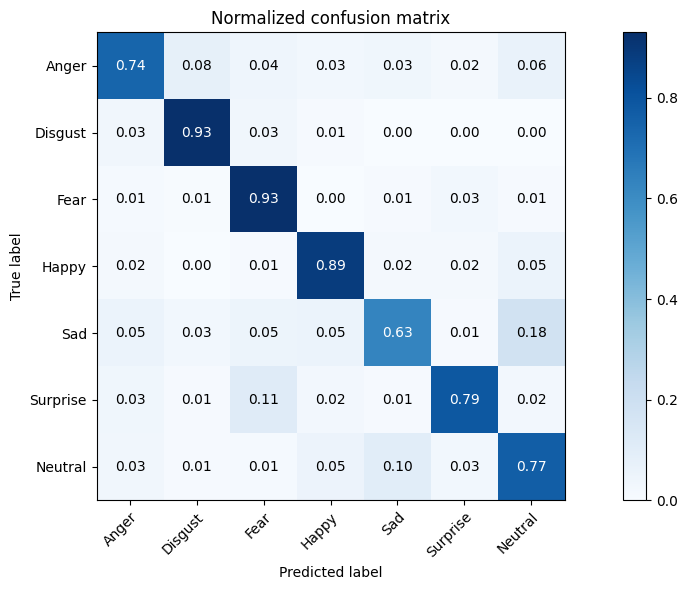

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(validation_Y_true, validation_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
loss, acc = model_C.evaluate(test_X, test_Y)

151/151 [==============================] - 1s 7ms/step - loss: 0.5413 - accuracy: 0.7913


In [ ]:
test_Y_pred = model_C.predict(test_X)

151/151 [==============================] - 1s 4ms/step


In [ ]:
test_Y_true = np.argmax(test_Y, axis=1)
test_Y_pred = np.argmax(test_Y_pred, axis=1)

In [ ]:
# Classification report.
print(classification_report(test_Y_true, test_Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       622
           1       0.51      0.93      0.65        99
           2       0.77      0.93      0.84       574
           3       0.86      0.89      0.87       935
           4       0.70      0.63      0.66       656
           5       0.86      0.79      0.82       647
           6       0.81      0.77      0.79      1290

    accuracy                           0.79      4823
   macro avg       0.76      0.81      0.77      4823
weighted avg       0.80      0.79      0.79      4823



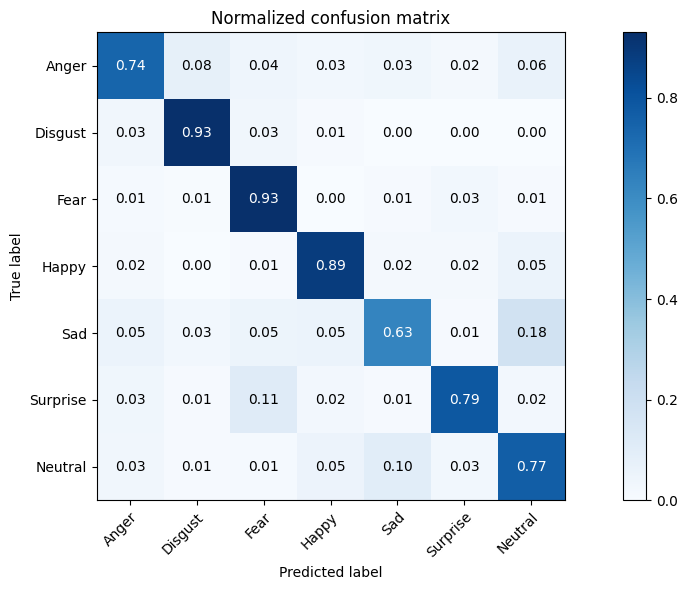

In [ ]:
emotion_mapping = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot normalized confusion matrix
plot_confusion_matrix(test_Y_true, test_Y_pred, classes=emotion_mapping, normalize=True, title='Normalized confusion matrix')
plt.show()